# Importing the libraries

In [ ]:
from sklearn.datasets import fetch_lfw_people
import keras
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras.backend as K
from math import *

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from keras.utils.np_utils import to_categorical

## Setting the seeds for Reproducibility.
seed = 3141
np.random.seed(seed)

import cv2
import numpy as np
import dlib

#importing helpfull functions
from utils import rearrange_arr, make_patchs, generate_triplets, dataset_config_doublet, dataset_config_triplet

# Importing the LFW dataset

In [ ]:
# Importing LFW dataset
lfw_people = fetch_lfw_people(data_home='.', resize=1, min_faces_per_person=10, color=True)

In [ ]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w, d = lfw_people.images.shape

# for machine learning we use the 2 data directly
X = lfw_people.data
n_features = X.shape[1]

# the label to predict is the id of the person
y = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [ ]:
# input image dimensions
X = X.reshape(n_samples, h, w, d)
# Trasforming labels from str to categorical
y = to_categorical(y)

In [ ]:
patchs_train, patchs_test, patchs_validation, y_train, y_test, y_validation = make_patchs(X, y)

# Triplet network

In [ ]:
#Importing the necessary libraries for the training
import torch
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.autograd import Variable

# Set up the network and training parameters
from networks import MultiPatch, TripletNet
from losses import TripletLoss
from trainer import fit
from metrics import TripletMetric

In [ ]:
Data_train_triplet, Data_val_triplet = dataset_config_triplet(patchs_train, patchs_validation, y_train, y_validation)

In [ ]:
batch_size=25
cuda = torch.cuda.is_available()

kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
    triplet_train_loader_triplet = [torch.utils.data.DataLoader(Data_train_triplet[i], batch_size=batch_size, shuffle=True, **kwargs) for i in range(7)]
    triplet_test_loader_triplet = [torch.utils.data.DataLoader(Data_val_triplet[i], batch_size=batch_size, shuffle=False, **kwargs) for i in range(7)]

Configuring the number of patches

In [ ]:
nb_patch = 7

In [ ]:
margin = 1.
multi_patch = MultiPatch()
model = TripletNet(multi_patch, nb_patch)
del(multi_patch)
if cuda:
  model.cuda()
loss_fn = TripletLoss(margin)
#triplet_loss = torch.nn.TripletMarginLoss(margin=1.0, p=2)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 50
log_interval = 100

Training the model

In [ ]:
tr_loss, vl_loss, Acc_tr, Acc_vl = fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, nb_patch = 7, margin = margin, metrics=[AccumulatedAccuracyMetric()])

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/2250 (0%)]	Loss: 0.996859	Accuracy: 0.0
Epoch: 1/50. Train set: Average loss: 1.4938	Accuracy: 0.30977777777777776
Epoch: 1/50. Validation set: Average loss: 0.2333	Accuracy: 0.6266666666666667
Train: [0/2250 (0%)]	Loss: 0.580722	Accuracy: 0.52
Epoch: 2/50. Train set: Average loss: 0.5636	Accuracy: 0.44355555555555554
Epoch: 2/50. Validation set: Average loss: 0.2684	Accuracy: 0.7
Train: [0/2250 (0%)]	Loss: 0.321391	Accuracy: 0.48
Epoch: 3/50. Train set: Average loss: 0.3710	Accuracy: 0.6346666666666667
Epoch: 3/50. Validation set: Average loss: 0.1194	Accuracy: 0.8933333333333333
Train: [0/2250 (0%)]	Loss: 0.174749	Accuracy: 0.72
Epoch: 4/50. Train set: Average loss: 0.2629	Accuracy: 0.764
Epoch: 4/50. Validation set: Average loss: 0.0775	Accuracy: 0.9066666666666666
Train: [0/2250 (0%)]	Loss: 0.084947	Accuracy: 0.88
Epoch: 5/50. Train set: Average loss: 0.1733	Accuracy: 0.8311111111111111
Epoch: 5/50. Validation set: Average loss: 0.1014	Accuracy: 0.8266666666666667
Train: 

 Saving the model weights

In [ ]:
torch.save(model.state_dict(), 'triplet_lfw_'+str(nb_patch))

Saving the Loss and Accuracy for each epoch

In [ ]:
np.save("loss_tr_lfw_"+str(nb_patch), tr_loss)
np.save("loss_vl_lfw_"+str(nb_patch), vl_loss)
np.save("acc_tr_lfw_"+str(nb_patch), Acc_tr)
np.save("acc_vl_lfw_"+str(nb_patch), Acc_vl)

Visualizing the results

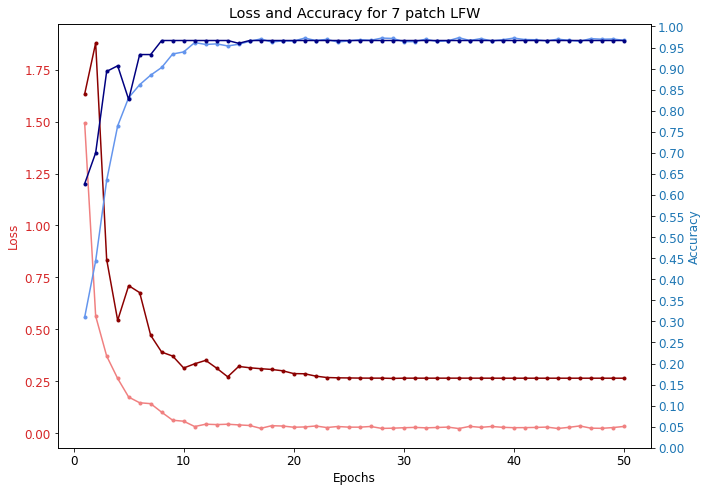

In [ ]:
X = range(1, 51)
fig, ax1 = plt.subplots()
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({'font.size': 12})
plt.title('Loss and Accuracy for '+str(nb_patch)+' patch LFW')
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel("Loss", color=color)
ax1.plot(list(X), tr_loss,'.-', label='train', color = 'lightcoral')
ax1.plot(list(X), vl_loss,'.-', label='validation', color = 'darkred')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(list(X), Acc_tr, '.-', label='train', color = 'cornflowerblue')
ax2.plot(list(X), Acc_vl, '.-', label='validation', color = 'navy')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([i/20 for i in range(21) ])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

# Siamese network


In [ ]:
Data_train_doublet, Data_val_doublet = dataset_config_triplet(patchs_train, patchs_validation, y_train, y_validation)

In [ ]:
batch_size = 25
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
triplet_train_loader_doublet = [torch.utils.data.DataLoader(Data_train_doublet[i], batch_size=batch_size, shuffle=True, **kwargs) for i in range(7)]
triplet_test_loader_doublet = [torch.utils.data.DataLoader(Data_val_doublet[i], batch_size=batch_size, shuffle=False, **kwargs) for i in range(7)]

In [ ]:
# Set up the network and training parameters
from networks import MultiPatch, SiameseNet
from losses import ContrastiveLoss
from trainer import fit
from metrics import ContrastiveMetric

In [ ]:
nb_patch = 7

In [ ]:
margin = 1.
multi_patch = MultiPatch()
model = SiameseNet(multi_patch, nb_patch = nb_patch)
del(multi_patch)
if cuda:
  model.cuda()
loss_fn = ContrastiveLoss(margin)
#triplet_loss = torch.nn.TripletMarginLoss(margin=1.0, p=2)
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 50
log_interval = 100

In [ ]:
tr_loss, vl_loss, Acc_tr, Acc_vl = fit(triplet_train_loader, triplet_test_loader, model, loss_fn, optimizer, scheduler, n_epochs, cuda, log_interval, nb_patch = nb_patch, margin = margin, metrics=[ContrastiveMetric()])

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train: [0/3000 (0%)]	Loss: 0.152470	Accuracy: 0.6
Train: [2500/3000 (83%)]	Loss: 2.509177	Accuracy: 0.5247524752475248
Epoch: 1/50. Train set: Average loss: 2.1139	Accuracy: 0.5226666666666666
Epoch: 1/50. Validation set: Average loss: 0.0951	Accuracy: 0.565
Train: [0/3000 (0%)]	Loss: 0.133215	Accuracy: 0.56
Train: [2500/3000 (83%)]	Loss: 0.127674	Accuracy: 0.5295049504950495
Epoch: 2/50. Train set: Average loss: 0.1275	Accuracy: 0.532
Epoch: 2/50. Validation set: Average loss: 0.1153	Accuracy: 0.51
Train: [0/3000 (0%)]	Loss: 0.128032	Accuracy: 0.52
Train: [2500/3000 (83%)]	Loss: 0.120452	Accuracy: 0.5413861386138614
Epoch: 3/50. Train set: Average loss: 0.1211	Accuracy: 0.5413333333333333
Epoch: 3/50. Validation set: Average loss: 0.1135	Accuracy: 0.51
Train: [0/3000 (0%)]	Loss: 0.137109	Accuracy: 0.36
Train: [2500/3000 (83%)]	Loss: 0.121311	Accuracy: 0.5386138613861386
Epoch: 4/50. Train set: Average loss: 0.1184	Accuracy: 0.5483333333333333
Epoch: 4/50. Validation set: Average loss:

In [ ]:
np.save("loss_tr_siamese_lfw_"+str(nb_patch), tr_loss)
np.save("loss_vl_siamese_lfw_"+str(nb_patch), vl_loss)
np.save("acc_tr_siamese_lfw_"+str(nb_patch), Acc_tr)
np.save("acc_vl_siamese_lfw_"+str(nb_patch), Acc_vl)

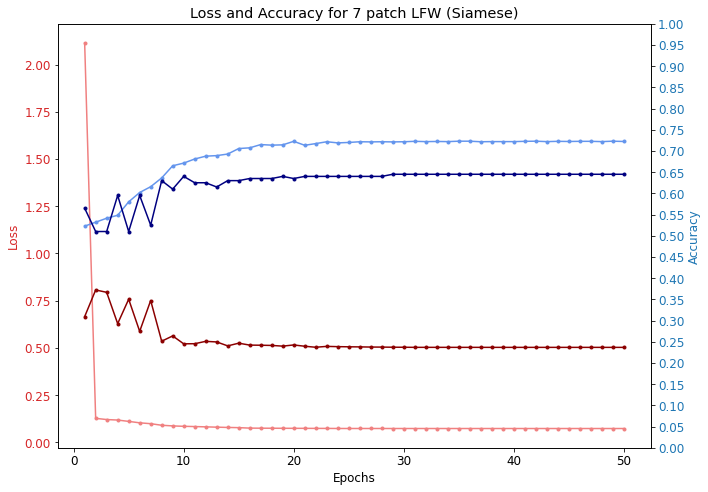

In [ ]:
X = range(1, 51)
fig, ax1 = plt.subplots()
plt.rcParams["figure.figsize"] = (10, 7)
plt.rcParams.update({'font.size': 12})
plt.title('Loss and Accuracy for '+str(nb_patch) +' patch LFW (Siamese)')
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel("Loss", color=color)
ax1.plot(list(X), tr_loss,'.-', label='train', color = 'lightcoral')
ax1.plot(list(X), vl_loss,'.-', label='validation', color = 'darkred')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(list(X), Acc_tr, '.-', label='train', color = 'cornflowerblue')
ax2.plot(list(X), Acc_vl, '.-', label='validation', color = 'navy')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([i/20 for i in range(21) ])
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()